## **Agentic-AI Primer: LLM Drives Reinforcement Learning (RL) Environment**
### A SIMPLE SPEND OPTIMIZATION USE CASE 

WIP Version: 1 <br>
Last Updated:  3/25/2025 <br>
This workbook is the companion code to this <a href="https://decisionsciences.blog/2025/03/26/workbook-agentic-ai-letting-llms-control-marketing-spend-with-reinforcement-learning-part-2/" target="blank">blog post</a> on decisionsciences.blog</br>

***

## Import Libraries: ##

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import langgraph
import os
import sqlite3
from sqlalchemy import create_engine
import requests
import warnings
import optuna
import openai

In [3]:
# colors for plotting
ppt_grey = "#5B738B"
ppt_dark_grey = "#666666"
ppt_medium_grey = "#999999"
ppt_lightgrey = "#CCCCCC"
ppt_blue = "#1B90FF"
ppt_red = "#EE3939"
ppt_rasp = "#FA4F96"
ppt_pink = "#F31DED"

## Set View Options: ##

In [4]:
# turn off warnings
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
#set some options for the output
get_ipython().magic(u'matplotlib inline')
pd.set_option('display.notebook_repr_html', True) 
pd.set_option('display.max_columns', 45) 
pd.set_option('display.max_rows', 40) 
pd.set_option('display.width', 180)
pd.set_option('display.max_colwidth', 240)  # or 199
sns.set_style("whitegrid", {'axes.grid' : False})

In [5]:
#set openai.api_key to the OPEN AI environment (stored in system environment to project key)
openai.api_key = os.environ["OPENAI_API_KEY"]


## Introduction to the Simple Marketing Spend Optimization Model

This notebook demonstrates a **marketing spend optimization** scenario, originally framed as a basic **reinforcement learning (RL)** problem. The twist is that instead of letting a learned RL policy drive the environment, we let a **large language model (LLM)** decide each action step by step. While not the standard approach to RL, it offers a transparent, “Agentic AI” perspective: the LLM “thinks out loud,” selects actions in natural language, and interacts with the environment in real time.

#### Business Overview

Imagine you’re a marketing team and you want to find the **optimal spend** on marketing that maximizes your **return** (e.g., revenue or profit). Traditionally, a **reinforcement learning** system might explore different spend levels, observe the resulting rewards, and converge on a near-optimal policy. Here, we shift that control to a **language model**—still aiming to maximize net profit, but in a more **conversational, transparent** style.

#### Key Model Factors

- **Spend**: The amount of money allocated to marketing.  
- **Revenue**: A parabolic function of spend, increasing up to a point before declining.  
- **Cost**: Directly proportional to spend, with a specified cost factor.  
- **Net Profit**: Defined as `revenue - cost`, and serves as the reward.

#### Objective

Regardless of whether a **traditional RL agent** or an **LLM** is steering the decisions, the **objective** remains the same: **maximize net profit** by finding the best spend level (or sequence of spend decisions). We simulate a simple marketing campaign where the environment returns net profit based on each action (e.g., increase or decrease spend by \$1).

#### From RL to Agentic AI

In a typical **reinforcement learning** loop, an agent explores the environment, taking actions and updating its **policy**—the decision-making rule—over many episodes. However, in this notebook, we **replace** that hidden policy with a **language model** that calls “tools” to reset or step the environment. This approach is more **transparent**: you can watch the LLM reason about each step, see the reward, and decide whether to raise, lower, or keep spend the same. While not necessarily as efficient as a standard RL policy, it demonstrates a more **conversational, flexible** approach, aligning with the concept of **Agentic AI**—where a language model actively controls the environment in a human-readable way.

### Understanding the Parabolic Revenue Function:

In our model, revenue follows a `simple parabolic function` that has a peak at a spend value of 5.0, as shown in the following equation:

$
\text{Revenue} = -(s - 5)^2 + 25
$

Where:
- $( s $) is the spend level.
- The revenue decreases as the spend moves further from 5.

This function captures the idea that while higher spending may initially increase revenue, beyond a certain point, the return on investment decreases.

### Why a Parabolic Function?
This model assumes `diminishing returns` on marketing spend, where too much spend leads to inefficiency. For example:
- **Under-spending** may miss opportunities to reach potential customers.
- **Over-spending** leads to inefficient allocation and diminishing returns.

The goal is to find the optimal balance that `maximizes net profit`.


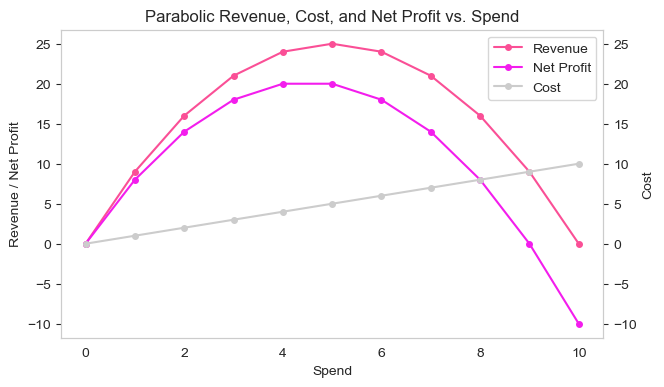

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 1) Generate data
spend_values = np.arange(0, 11, 1)
revenue = -(spend_values - 5)**2 + 25
cost = spend_values * 1.0
net_profit = revenue - cost

# 2) Create the figure and two axes
fig, ax1 = plt.subplots(figsize=(7, 4))

# 'ax2' will share the same x-axis but can have a separate y-axis
ax2 = ax1.twinx()

# 3) Plot revenue and net profit on ax1
lns1 = ax1.plot(spend_values, revenue, label="Revenue", marker='o', markersize=4, color=ppt_rasp)
lns2 = ax1.plot(spend_values, net_profit, label="Net Profit", marker='o', markersize=4, color=ppt_pink)

# 4) Plot cost on ax2
# (Choose a distinct color or re-use your palette as needed)
lns3 = ax2.plot(spend_values, cost, label="Cost", marker='o', markersize=4,color=ppt_lightgrey)

# 5) Force ax2 to match ax1's y-limits so they share the same numeric scale
ax2.set_ylim(ax1.get_ylim())

# 6) Combine legends from both axes
lines = lns1 + lns2 + lns3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc="best")

# 7) Label the axes
ax1.set_xlabel("Spend")
ax1.set_ylabel("Revenue / Net Profit")
ax2.set_ylabel("Cost")

# 8) Add title and show
plt.title("Parabolic Revenue, Cost, and Net Profit vs. Spend")
plt.show()

#### What This Plot Shows:
- `Revenue`: peaks at spend = 5 (where it hits 25).
- `Cost`: increases linearly with spend (cost factor = 1.0).
- `Net Profit`: the difference between revenue and cost, reaching its `maximum at spend 4 or 5 (net profit=20)`.

This visualization confirms the `theoretical sweet spot` for spending, which the RL agent should ideally discover through trial and error.

## The Environment: SimpleMarketingEnv Class

In reinforcement learning (RL), **OpenAI Gym** is a widely used library that provides a standard interface for creating and interacting with environments. In our case, we’ve built a custom environment, **`SimpleMarketingEnv`**, to simulate the marketing spend optimization problem.

The environment is designed to be **small and simplified** with **known properties**. This setup allows us to clearly **diagnose how the LLM-driven process is making decisions** and whether it is maximizing net profit. By making the **dynamics and optimal policy clear**, we can easily monitor whether the language model (LLM) is following the correct reasoning process.

#### Key Features of the Environment:

1. **Single State Variable: Marketing Spend**  
   The environment’s state is just a single variable: **marketing_spend**. This makes it easy to track and visualize how the LLM decides to adjust spend and see the resulting rewards.

2. **Reward Function with Diminishing Returns**  
   We’ve defined a **known revenue function** that has diminishing returns as spend increases, with a peak at the optimal spend level. The reward is calculated by subtracting the cost from the revenue generated by the spend. This simple function gives us a clear idea of what the optimal spend should be.

3. **Discrete Action Space**  
   The available actions are discrete, meaning the LLM can choose from three options:
   - **0 = no change** in spend
   - **1 = increase spend by 1**
   - **2 = decrease spend by 1**
<br>&nbsp;

4. **Known Optimal Strategy**  
   The parameters of the environment are chosen such that we know the optimal spend in advance. This makes it easy to validate whether the LLM is learning the correct strategy—**maximizing net profit** by adjusting spend levels appropriately.

With this setup, we can clearly observe how the **LLM drives** the environment step by step. Instead of relying on an RL policy to explore and exploit, the LLM directly interacts with the environment, adjusting actions based on natural language reasoning. By controlling these elements, we can assess whether the LLM is converging toward the optimal solution—**not just in terms of rewards but also through the transparency of its decision-making process**.

### 1. Set-up Base Environment (Gym)
In this step, we create the `base environment` using Gymnasium, a widely used library for developing and comparing reinforcement learning (RL) algorithms. `SimpleMarketingEnv` is a custom environment that simulates our marketing spend optimization scenario.

In [7]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding

class SimpleMarketingEnv(gym.Env):
    """
    A simple marketing environment using Gymnasium.
    The agent controls a single 'spend' variable in [0..max_spend].
    Each step, the agent picks one of three actions:
      0 = stay,
      1 = increase spend by 1,
      2 = decrease spend by 1.
    The environment calculates a parabolic revenue function minus cost.
    """

    metadata = {"render_modes": ["human"]}

    def __init__(self, max_spend=10, cost_factor=1.0, max_steps=1000):
        super().__init__()
        self.max_spend = max_spend
        self.cost_factor = cost_factor
        self.max_steps = max_steps

        # Observation space: single float in [0, max_spend]
        self.observation_space = spaces.Box(
            low=np.array([0], dtype=np.float32),
            high=np.array([float(max_spend)], dtype=np.float32),
            shape=(1,),
            dtype=np.float32
        )

        # Action space: Discrete(3) -> {0=stay, 1=+1, 2=-1}
        self.action_space = spaces.Discrete(3)

        self.state = None
        self.current_step = 0
        self._np_random, _ = seeding.np_random()  # default seeding

    def seed(self, seed=None):
        """
        Optional: If you want reproducible randomness,
        call env.seed(some_seed) before reset().
        """
        self._np_random, _seed = seeding.np_random(seed)
        return [_seed]

    def reset(self, seed=None, options=None):
        """
        Resets the environment.
        Returns (observation, info).
        """
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        self.current_step = 0
        # Start at a random spend from 0..max_spend
        # NOTE: use 'integers(...)' instead of 'randint(...)' in new NumPy
        initial_spend = self._np_random.integers(0, self.max_spend + 1)
        self.state = np.array([float(initial_spend)], dtype=np.float32)

        info = {}
        return self.state, info

    def step(self, action):
        """
        Applies the given action (0=stay, 1=+1, 2=-1).
        Returns (observation, reward, terminated, truncated, info).
        """
        spend = float(self.state[0])
        if action == 1:   # increase
            spend += 1
        elif action == 2: # decrease
            spend -= 1
        spend = np.clip(spend, 0, self.max_spend)

        # Parabolic revenue: -(spend - 5)^2 + 25
        revenue = -(spend - 5)**2 + 25
        cost = spend * self.cost_factor
        reward = revenue - cost

        self.state = np.array([spend], dtype=np.float32)
        self.current_step += 1

        terminated = False  # set True if you want a specific terminal condition
        truncated = (self.current_step >= self.max_steps)
        info = {}

        return self.state, reward, terminated, truncated, info

    def render(self):
        """
        Optional: print or visualize the environment's state.
        """
        print(f"Step {self.current_step}, Spend={self.state[0]}")


### 2. Define Tools for LangChain

To allow the LLM to control the environment, we expose three tools that the LLM can call during its decision-making process:

- **`reset_env`**: Resets the environment and returns the initial spend level.
- **`step_env`**: Takes an action (0 = stay, 1 = increase spend by 1, 2 = decrease spend by 1), and returns the new spend, the immediate reward, and whether the episode has ended.
- **`stop_env`**: Finalizes the environment run when the LLM believes the optimal spend has been reached, signaling that no further actions should be taken.

These tools allow the LLM to interact with the environment step by step, making it capable of experimenting with different spend levels and evaluating the resulting rewards.

In [8]:
###############################
# Create Tools for the LLM #
###############################
from langchain.agents import Tool
from typing import Optional

marketing_env = SimpleMarketingEnv()

def reset_env_tool(_input: str) -> str:
    obs, _ = marketing_env.reset()
    return f"Environment reset. Current spend={obs[0]}, step=0"

def step_env_tool(action_str: str) -> str:
    try:
        action = int(action_str)
    except ValueError:
        return "Invalid action. Please provide 0, 1, or 2."

    obs, reward, done, truncated, info = marketing_env.step(action)
    step_info = f"Action={action}, new spend={obs[0]:.1f}, reward={reward:.1f}, done={done or truncated}"
    return step_info

def stop_env_tool(_input: str) -> str:
    return "Stop requested. Finalizing environment run."

tools = [
    Tool(
        name="reset_env",
        func=reset_env_tool,
        description="Reset the environment to start a new episode."
    ),
    Tool(
        name="step_env",
        func=step_env_tool,
        description="Take an action in the environment: 0=stay, 1=increase, 2=decrease."
    ),
    Tool(
        name="stop_env",
        func=stop_env_tool,
        description="Stop the environment run."
    )
]


#### 3. Create an LLM Agent That Uses These Tools

In this section of the code, the primary focus is on setting up the **conversation memory** for the agent and initializing it with LangChain and OpenAI's language model (LLM). Here's a breakdown of the key components:

- **Conversation Memory Setup**: A `ConversationBufferMemory` object is created to store the history of the conversation. This memory ensures that the LLM has access to the entire conversation context, allowing it to maintain continuity and refer back to previous actions and decisions.

- **LLM Initialization**: The language model (LLM), powered by OpenAI’s GPT-3.5, is initialized with a temperature of 0 to make the model deterministic (i.e., it will always give the same response for the same input).

- **Agent Initialization**: An **AgentExecutor** is created using the LangChain `initialize_agent` function. The agent is provided with tools (to interact with the marketing environment), the LLM for decision-making, and the memory object for tracking the conversation. The agent is configured to use a **ZERO_SHOT_REACT_DESCRIPTION** agent type, meaning it will generate step-by-step reasoning and responses based on its input, while **handle_parsing_errors=True** ensures that any parsing issues are caught and handled.

- **Prompt**: The custom prompt provided to the agent guides the decision-making process. It outlines the goal (to maximize net profit), the actions the agent can take (resetting the environment, stepping through actions, or stopping), and how the agent should proceed by tracking rewards, trying different strategies, and finalizing its solution when it believes it has optimized the net profit.

- **Response Handling**: The agent's response is captured and printed, with the final response being displayed to the user as the agent's conclusion after completing its task.

This setup ensures that the agent has memory, allowing it to reason over previous actions and decisions, which helps in optimizing the marketing spend while maintaining context throughout the process.

In [9]:
# hide langchain depreciation warning 
import warnings
warnings.filterwarnings('ignore')

############################################
#  Add Conversation Memory to the Agent 
############################################
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, initialize_agent, AgentType

# Create a memory object that stores all conversation history
memory = ConversationBufferMemory(memory_key="chat_history")

# Initialize the LLM (ChatOpenAI) with zero temperature
llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-3.5-turbo"  # or "gpt-4" if you have access
)

# Pass the memory object to the agent, so it can see the entire conversation
agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    memory=memory,
    handle_parsing_errors=True
)

###############################
# Provide the custom prompt
###############################
prompt = """
You are an AI controlling a marketing spend environment.
Actions:
 - reset_env -> resets environment
 - step_env -> step the environment with an action: 0=stay, 1=+1, 2=-1
 - stop_env -> finalize your solution

Goal: maximize net profit by choosing good actions. 
Keep track of the highest reward you've encountered so far. 
Try multiple actions, including lowering or increasing spend all the way if needed, until you confirm you can't do better. 
If no improvement occurs over a few steps, continue experimenting until you are confident the solution cannot be improved further.
Please keep calling step_env until you believe you've maximized net profit or see no further improvement. 
Then call stop_env or just give your final answer.
"""

#response = agent.invoke(prompt)
#print("\nFinal Agent Response:\n", response)

response = agent.invoke(prompt)
final_text = response.get("output", "")
print("\nFinal Agent Response:\n", final_text)



> Entering new AgentExecutor chain...
I need to start by resetting the environment to begin a new episode and maximize net profit.
Action: reset_env
Action Input: N/A
Observation: Environment reset. Current spend=7.0, step=0
I should start by increasing the spend to see if it improves the net profit.
Action: step_env
Action Input: 1
Observation: Action=1, new spend=8.0, reward=8.0, done=False
Increasing the spend improved the net profit. I should continue increasing it to see if it gets better.
Action: step_env
Action Input: 1
Observation: Action=1, new spend=9.0, reward=0.0, done=False
The reward decreased when I increased the spend further. I should try decreasing the spend now.
Action: step_env
Action Input: 2
Observation: Action=2, new spend=8.0, reward=8.0, done=False
Decreasing the spend improved the net profit. I should continue decreasing it to see if it gets better.
Action: step_env
Action Input: 2
Observation: Action=2, new spend=7.0, reward=14.0, done=False
Decreasing the 

#### How It Works
- `initialize_agent(...)`: We create a “ZeroShot” ReAct agent that can call the reset_env and step_env tools.
- `prompt`: We instruct the LLM to behave like a “marketing spend controller.”
- `agent.run(prompt)`: The LLM will read your instructions and begin calling reset_env and step_env as needed, producing a chain-of-thought in the background. The final answer is a short summary from the LLM.

#### Example Interaction
You might see the LLM do something like:

- Call reset_env to start a new episode.
- Observe “Environment reset. Current spend=8.0, step=0.”
- Decide “We’re at 8, that’s above 5, so we should do action=2 to decrease.”
- Call step_env("2").
- Observe the new state, reward, etc.
- Repeat until it thinks it has done enough steps or sees “done=True.”

#### Why This Is “Agentic AI”
Instead of a policy network (like PPO) automatically picking actions, the LLM uses natural language reasoning to decide each step. It queries the environment via tools, sees the reward, and updates its chain-of-thought accordingly. While this might not be as sample-efficient as standard RL, it demonstrates how an LLM can orchestrate environment interactions—a hallmark of Agentic AI.